# Proximal Subgradient Method

In [1]:
using DataFrames
using Plots
using LowRankModels

# Quadratic Loss + l1 Regularizer

In [2]:
function prox_l1(x::Number, alpha=1)
    if x > alpha
        return x-alpha
    elseif x < -alpha
        return x + alpha
    else
        return 0
    end
end

function prox_l1(x::AbstractArray, alpha=1)
    return reshape(Float64[prox_l1(xi, alpha) for xi in x], size(x))
end

function proxgrad_quad_l1(X, y, w; maxiters = 150, stepsize = 1/L, λ = 1)
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = 2X'*(X*w-y) # compute quadratic gradient
        w = w - stepsize*g
        # prox step
        w = prox_l1(w, stepsize*λ)
        # record objective value
        push!(objval, norm(X*w-y)^2 + norm(w,1))
    end
    return w, objval
end

proxgrad_quad_l1 (generic function with 1 method)

In [3]:
training_set = readtable("training_data.csv",header = true)
test_set = readtable("test_data.csv",header = true)
test_set[:percentile] = test_set[:finishing_position]./test_set[:race_total]

y_training = Array{Float64}(training_set[:, :percentile])
X_training = Array{Float64}([training_set[:,[:actual_weight, :declared_horse_weight, :draw, :win_odds, 
            :trainer_avg_percentile, :jockey_avg_percentile, :horse_avg_percentile]] ones(size(training_set,1))])

L = (2*maximum(abs.(svdfact(X_training)[:S])))^2

w = X_training\y_training
w, obj = proxgrad_quad_l1(X_training, y_training, w)

w

8-element Array{Float64,1}:
  0.000597119
  8.4043e-5  
  0.00392443 
  0.00223611 
 -0.150999   
  0.324998   
  0.71316    
 -0.200463   


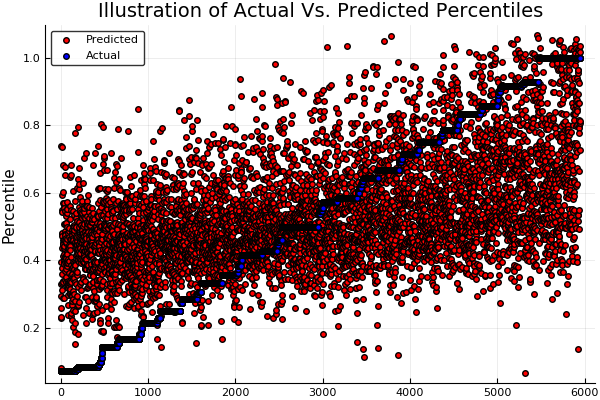

In [4]:
X_test = Array{Float64}([test_set[:,[:actual_weight, :declared_horse_weight, :draw, :win_odds, 
        :trainer_avg_percentile, :jockey_avg_percentile, :horse_avg_percentile]] ones(size(test_set,1))])
y_test = Array{Float64}(test_set[:,:percentile])
predicted = X_test*w

predicted = predicted[sortperm(y_test)]
y_test = sort(y_test)

scatter(predicted, color = "red", ylabel = "Percentile", label = "Predicted", 
    title = "Illustration of Actual Vs. Predicted Percentiles")
scatter!(y_test, color = "blue", label = "Actual")

In [5]:
w

8-element Array{Float64,1}:
  0.000597119
  8.4043e-5  
  0.00392443 
  0.00223611 
 -0.150999   
  0.324998   
  0.71316    
 -0.200463   


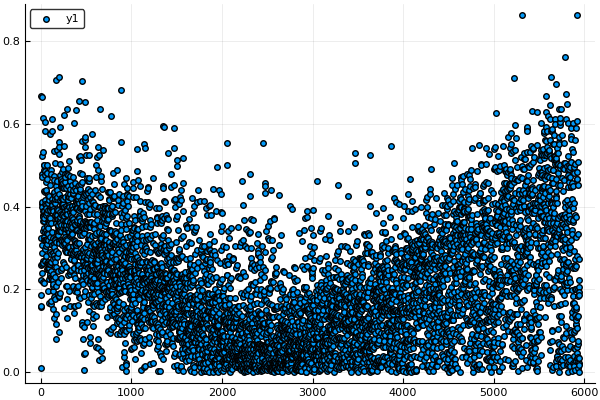

In [6]:
scatter(abs.(y_test .- predicted))

In [7]:
mean(abs.(y_test .- predicted))

0.2116460813002766

# Huber Loss + Non-Negative Regularizer

In [8]:
import LowRankModels: evaluate, grad
evaluate(loss::Loss, X::Array{Float64,2}, w, y) = evaluate(loss, X*w, y)
grad(loss::Loss, X::Array{Float64,2}, w, y) = X'*grad(loss, X*w, y)

grad (generic function with 18 methods)

In [9]:
function proxgrad(loss, reg, X, y; maxiters = 10, stepsize = 1/L)
    w = X\y
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = grad(loss, X, w, y)
        z = w - stepsize*g
        # prox step
        w = prox(reg, z, stepsize)
        # record objective value
        push!(objval, evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w, objval
end

proxgrad (generic function with 1 method)


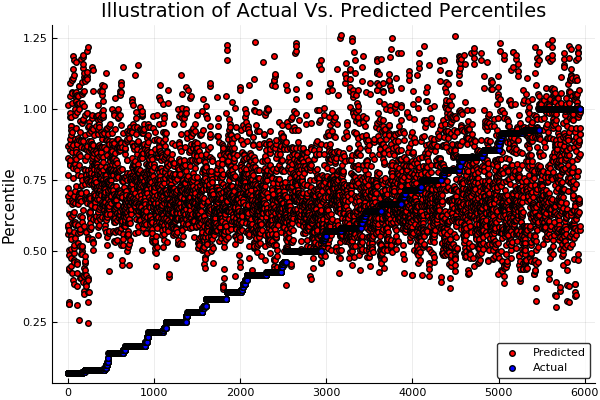

In [15]:
loss = HuberLoss()
reg = NonNegConstraint()

w, obj = proxgrad(loss,reg,X_training,y_training)

predicted = X_test*w

predicted = predicted[sortperm(y_test)]
y_test = sort(y_test)

scatter(predicted, color = "red", ylabel = "Percentile", label = "Predicted", 
    title = "Illustration of Actual Vs. Predicted Percentiles")
scatter!(y_test, color = "blue", label = "Actual")

In [11]:
mean(abs.(y_test .- predicted))

0.2116460813002766

# Simple Least Squares Regression


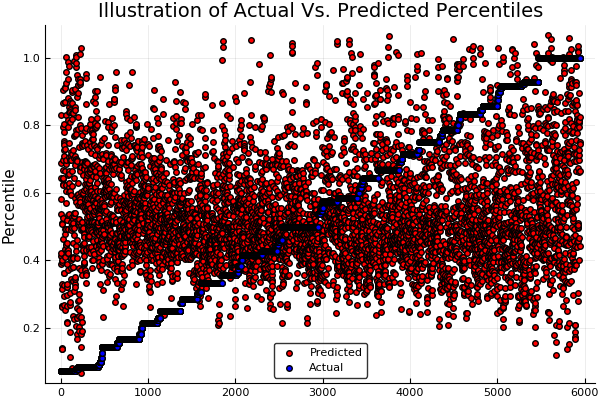

In [12]:
w = [X_training ones(size(X_training,1))]\y_training

predicted = [X_test ones(size(X_test,1))]*w

predicted = predicted[sortperm(y_test)]
y_test = sort(y_test)

scatter(predicted, color = "red", ylabel = "Percentile", label = "Predicted", 
    title = "Illustration of Actual Vs. Predicted Percentiles")
scatter!(y_test, color = "blue", label = "Actual")

# Logistic


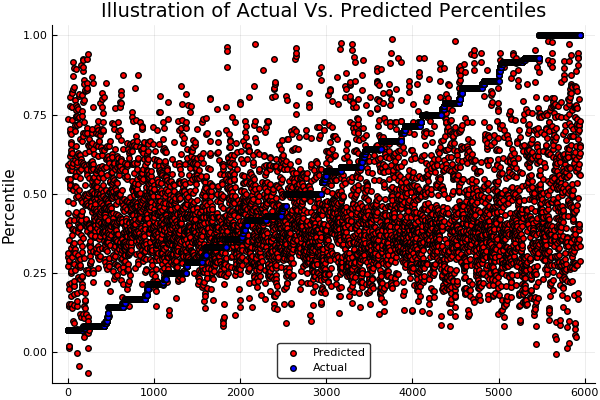

In [13]:
w[1] = 0.0006327026
w[2] = 0.00007901228
w[3] = 0.005027411
w[4] = 0.002221049
w[5] = -0.1313111
w[6] = 0.3620552
w[7] = 0.7467478
w[8] = -.2580604

predicted = [X_test ones(size(X_test,1))]*w

predicted = predicted[sortperm(y_test)]
y_test = sort(y_test)

scatter(predicted, color = "red", ylabel = "Percentile", label = "Predicted", 
    title = "Illustration of Actual Vs. Predicted Percentiles")
scatter!(y_test, color = "blue", label = "Actual")

In [14]:
mean(abs.(y_test .- predicted))

0.2860801462877432